In [ ]:
# Load all the datasets from google drive
# Combine them into one data drive
# Look at the distribution of reports
# Create a similar classification taxonomy to the one adapted in the study
# Compare how LR with sentence embeddings trained in the Kenyan context performs as well as the XLM-R model

In [ ]:
# Add all the neccessary imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from functools import partial
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_fscore_support
from imblearn.pipeline       import Pipeline
from sklearn.model_selection import cross_validate
from imblearn.over_sampling  import RandomOverSampler
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from nltk.tokenize import TweetTokenizer
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
sns.set_theme()



%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [ ]:
pd.set_option('display.max_colwidth', None)

# Set the display width for other outputs (e.g., print statements)
from IPython.core.display import display, HTML
display(HTML("<style>pre {white-space: pre-wrap;}</style>"))

In [ ]:
#Util function to plot confusion matrix
def plot_cm_with_percentages(labels, predictions, class_labels, name):
    # Compute confusion matrix
    cm = confusion_matrix(labels, predictions)

    # Calculate row-wise sums to get the total counts for each true label
    row_sums = cm.sum(axis=1, keepdims=True)

    # Calculate the percentages by dividing each element of the confusion matrix by its corresponding row sum
    cm_percentages = np.round((cm / row_sums) * 100, decimals=2)

    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(8,6), dpi=100)

    # Scale up the size of all text
    sns.set(font_scale = 1.1)

    # Plot Confusion Matrix using Seaborn heatmap()
    # Parameters:
    # first param - confusion matrix in array format
    # annot = True: show the numbers in each heatmap cell
    # fmt = '.2f': show numbers as floats with 2 decimal places
    ax = sns.heatmap(cm_percentages, annot=True, fmt='.2f', cbar=False)

    # Format the annotations as percentages
    for _, value in enumerate(ax.collections[0].axes.texts):
        if value.get_text() != '0.00':
            value.set_text(f"{float(value.get_text()):.2f}%")

    # Set x-axis label and ticks
    ax.set_xlabel("Predicted Label", labelpad=20)
    ax.set_xticklabels(class_labels, fontsize=9, wrap=True)

    # Set y-axis label and ticks
    ax.set_ylabel("Gold Label", labelpad=20)
    ax.set_yticklabels(class_labels, fontsize=9, rotation=0, wrap=True)

    # Save the figure as an SVG file with timestamp in the file name
    plt.savefig(name, format='svg')

    plt.show()


In [ ]:
# Upload the data to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_csvs_from_folder(folder_path):
    # List all CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    # Create an empty list to store individual DataFrames
    data_frames = []

    # Loop through the CSV files and load each file into a DataFrame
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        data_frames.append(df)

    # Concatenate all DataFrames into one final DataFrame
    final_df = pd.concat(data_frames, ignore_index=True)

    return final_df

# Replace 'folder_path' with the path to your folder containing CSV files
folder_path = '/content/drive/My Drive/thesis/Nigerian Election Data'
result_df = load_csvs_from_folder(folder_path)

In [ ]:
# Print the number of labelled election reports from the dataset
print(f"The number of election reports:{result_df.shape}")

The number of election reports:(1707, 26)


In [ ]:
filter_columns = ['Post ID', 'Survey','Created (UTC)', 'Updated (UTC)',
       'Post Date (UTC)', 'Description', 'Classification']

In [ ]:
filtered_df = result_df[filter_columns]

In [ ]:
filtered_df.head()

,Post ID,Survey,Created (UTC),Updated (UTC),Post Date (UTC),Description,Classification
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52214.0,Polling Station Issues,2023-02-25 07:20:33,2023-02-25 07:29:44,2023-02-25 02:57:01,As of 8:10 am the polling unit was yet to be open and no INEC staff was available.,Polling Station Opening
2,52221.0,Polling Station Issues,2023-02-25 07:21:47,2023-02-25 10:41:17,2023-02-25 07:23:23,Untill now election materials have not been fully given to polling units.,Wrong or Inadequate Voting Material
3,52237.0,Polling Station Issues,2023-02-25 07:24:26,2023-02-25 07:26:57,2023-02-25 07:14:39,No INEC Officials present at the polling unit,Polling Station Opening
4,52266.0,Polling Station Issues,2023-02-25 07:30:58,2023-02-25 07:58:43,2023-02-25 07:34:00,No INEC officials yet,Polling Station Opening


In [ ]:
filtered_df.dropna(how='all', inplace=True)

<ipython-input-13-328e84c5b670>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.dropna(how='all', inplace=True)


In [ ]:
filtered_df.shape

(1700, 7)

In [ ]:
# Drop duplicates in the dataset
filtered_df.drop_duplicates(subset='Description', keep='first', inplace=True)

<ipython-input-15-8af7605ae70d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop_duplicates(subset='Description', keep='first', inplace=True)


In [ ]:
filtered_df.shape

(1051, 7)

In [ ]:
filtered_df.head()

,Post ID,Survey,Created (UTC),Updated (UTC),Post Date (UTC),Description,Classification
1,52214.0,Polling Station Issues,2023-02-25 07:20:33,2023-02-25 07:29:44,2023-02-25 02:57:01,As of 8:10 am the polling unit was yet to be open and no INEC staff was available.,Polling Station Opening
2,52221.0,Polling Station Issues,2023-02-25 07:21:47,2023-02-25 10:41:17,2023-02-25 07:23:23,Untill now election materials have not been fully given to polling units.,Wrong or Inadequate Voting Material
3,52237.0,Polling Station Issues,2023-02-25 07:24:26,2023-02-25 07:26:57,2023-02-25 07:14:39,No INEC Officials present at the polling unit,Polling Station Opening
4,52266.0,Polling Station Issues,2023-02-25 07:30:58,2023-02-25 07:58:43,2023-02-25 07:34:00,No INEC officials yet,Polling Station Opening
5,52274.0,Polling Station Issues,2023-02-25 07:31:05,2023-02-25 07:57:24,2023-02-25 07:18:15,"Registered Voters list placed on the wall but voters can't find their names on it. At the same time, they don't know where their voter information is located. This is cursing a bit of panic over here",Polling Station Opening


In [ ]:
grouped_counts = filtered_df.groupby('Survey').size()
print(grouped_counts)

Survey
Ballot Issues                      8
Polling Station Issues           600
Positive Events                  327
Security                          53
Sorting, Counting & Collation     63
dtype: int64


In [ ]:
# From the label distribution above, Political Rallies label was not applied in the Nigerian Context, model will be working with 4 labels, will be evaluated against 4 labels
# Combine Ballot Issues with Polling Station Issues
# Working with only four labels - Counting and Results Issues, Security Issues, Positive Events and Voting Issues - don't have any labels for Political Rallies
# Sample N posts from the Twitter results to be Non-Informative and then the ones shown in this to be informative
# Use that in the informative vs non-informative classification task
# Take the labelled informative dataset to be used in the second step
# Next step - Get Informative vs Non-Informative working
# Load twitter dataset with opinions and sample from them and then compare model performance in detecting informative and non-informative

In [ ]:
!pip3 install nltk emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=4d0a15c055b5efb534182c5561771f49143de500de5f6bc2427c1b083eb0be51
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji


In [ ]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer


tokenizer = TweetTokenizer()

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token

def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

In [ ]:
# Apply the normalize text function to the tweet column
filtered_df["normalized_text"] = filtered_df["Description"].map(normalizeTweet)

<ipython-input-22-e3b4a3c3720b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["normalized_text"] = filtered_df["Description"].map(normalizeTweet)


In [ ]:
## Check whether GPU is detected
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# Install transformers lib
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.7 MB/s eta 0:00:00


In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.5 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer
from transformers import XLMRobertaForSequenceClassification
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AutoModelForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
from transformers import get_linear_schedule_with_warmup
import os

In [ ]:
def init_tokenizer(model_name= 'xlm-roberta-base'):
  # Code to initialize tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  return tokenizer

def tokenize_sent(tokenizer, max_len, sentences, labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = max_len,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  # Uncomment to debug the code
  # print('Original: ', sentences[0])
  # print('Token IDs:', input_ids[0])

  return input_ids, attention_masks, labels

In [ ]:
def test_model(model,test_dataloader):
  # Put model in evaluation mode
  model.eval()
  # Tracking variables
  predictions , true_labels = [], []
  # Predict
  for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      return_dict=True)
    logits = result.logits
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
  return predictions, true_labels

In [ ]:
# Connect to the GPU.
device = torch.device('cuda')
# Report what GPU we were granted.
print('  GPU:', torch.cuda.get_device_name(0))

  GPU: Tesla V100-SXM2-16GB


In [ ]:
from sklearn.metrics import f1_score
def print_classification_report(predictions, true_labels, target_names, name):
  # Combine the results across all batches.
  flat_predictions = np.concatenate(predictions, axis=0)

    # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)

  # For each sample, pick the label (0 or 1) with the higher score.
  second_most_probable_class = np.argsort(-flat_predictions, axis=1)[:, 1]
  flat_predictions = np.array([second_most_probable_class[i] if flat_predictions[i].argmax() == 1 else flat_predictions[i].argmax() for i, target in enumerate(flat_true_labels)])

  # # Calculate the MCC
  # mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

  # print('Total MCC: %.3f' % mcc)
  print(f1_score(flat_true_labels, flat_predictions, average='macro'))
  print(classification_report(flat_true_labels, flat_predictions, target_names=target_names))

  plot_cm_with_percentages(flat_true_labels, flat_predictions, list(target_names), name)

  return flat_predictions

In [ ]:
# Information types classification task

In [ ]:
# How does a sentence transformer model perform on the data?

In [ ]:
#Load the Kenyan data, train the models, see how it performs on new context - do i need to evaluate this?

In [ ]:
# Load data
model_data = pd.read_csv('/content/drive/My Drive/thesis/labelled_election_reports_with_sent.csv', encoding='utf-8')
train_data = pd.read_csv('/content/drive/My Drive/thesis/train_election_reports_with_sent.csv', encoding='utf-8')
val_data = pd.read_csv('/content/drive/My Drive/thesis/val_election_reports_with_sent.csv', encoding='utf-8')
test_data = pd.read_csv('/content/drive/My Drive/thesis/test_election_reports_with_sent.csv', encoding='utf-8')

In [ ]:
labeller = LabelEncoder()
labeller.fit(train_data["informative_label"])
train_data["informative_target"] = labeller.transform(train_data["informative_label"])
test_data["informative_target"] = labeller.transform(test_data["informative_label"])

In [ ]:
mapping = dict(zip(labeller.classes_, range(len(labeller.classes_))))
print(mapping)

{'Informative': 0, 'Non-Informative': 1}


In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=d9d2ef614e4816ddaacdc8ed9fdabd3d5ad6d033c7ef2049cebd433f96b0e19f
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
# Import sentence transformers lib package
from sentence_transformers import SentenceTransformer

In [ ]:
embedder = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

In [ ]:
train_sentences = train_data.normalized_text.values
# val_sentences = val_data.normalized_text.values
# test_sentences = informative_test_data.normalized_text.values

In [ ]:
train_targets = train_data.informative_target.values

In [ ]:
print(train_targets.shape)

(9926,)


In [ ]:
train_embeddings = embedder.encode(train_sentences, device = device) # Probably save the embeddings - save the embeddings to like a pickle or something - took 30 minutes to run

In [ ]:
model_lr = LogisticRegression(max_iter=3000) # Set the max_iter to 1000 to fix convergence warning issue
model_lr.fit(train_embeddings, train_targets)

LogisticRegression(max_iter=3000)

In [ ]:
# How does the model perform on nigerian data

In [ ]:
# ng_embeddings = embedder.encode(ng_sentences, device=device)

In [ ]:
# ng_predictions = model_lr.predict(ng_embeddings)

In [ ]:
# print(classification_report(ng_predictions, ng_labels))

In [ ]:
# Test out information type classification

In [ ]:
filtered_df['Survey'].unique()

array(['Polling Station Issues', 'Security',
       'Sorting, Counting & Collation', 'Positive Events',
       'Ballot Issues'], dtype=object)

In [ ]:
# Rename Polling Station Issues to
filtered_df["label"] = filtered_df['Survey'].replace({'Polling Station Issues':"Voting Issues",'Ballot Issues':"Voting Issues", "Security":"Security Issues", "Sorting, Counting & Collation":"Counting and Results"})

<ipython-input-41-0ff5c5be6c80>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["label"] = filtered_df['Survey'].replace({'Polling Station Issues':"Voting Issues",'Ballot Issues':"Voting Issues", "Security":"Security Issues", "Sorting, Counting & Collation":"Counting and Results"})


In [ ]:
filtered_df['label'].unique()

array(['Voting Issues', 'Security Issues', 'Counting and Results',
       'Positive Events'], dtype=object)

In [ ]:
filtered_df.groupby(['label']).size()

label
Counting and Results     63
Positive Events         327
Security Issues          53
Voting Issues           608
dtype: int64

In [ ]:
informative_train_data = train_data[train_data["informative_label"] == 'Informative']

In [ ]:
labeller = LabelEncoder()
labeller.fit(informative_train_data["merged_label"])
informative_train_data['informative_target'] = labeller.transform(informative_train_data["merged_label"])

<ipython-input-45-b669dc79413c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_train_data['informative_target'] = labeller.transform(informative_train_data["merged_label"])


In [ ]:
mapping = dict(zip(labeller.classes_, range(len(labeller.classes_))))
print(mapping)

{'Counting and Results': 0, 'Political Rallies': 1, 'Positive Events': 2, 'Security Issues': 3, 'Voting Issues': 4}


In [ ]:
filtered_df['informative_target'] = labeller.transform(filtered_df["label"])

<ipython-input-47-dd605cd98d2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['informative_target'] = labeller.transform(filtered_df["label"])


In [ ]:
filtered_df['informative_target'].unique()

array([4, 3, 0, 2])

In [ ]:
train_sentences, train_targets = informative_train_data.normalized_text.values, informative_train_data.informative_target.values
test_sentences , test_targets = filtered_df.normalized_text.values, filtered_df.informative_target.values

In [ ]:
train_embeddings = embedder.encode(train_sentences, device=device)
model_lr = LogisticRegression(max_iter=3000, class_weight='balanced') # Set the max_iter to 1000 to fix convergence warning issue
model_lr.fit(train_embeddings, train_targets)
test_embeddings = embedder.encode(test_sentences, device=device)

NameError: ignored

In [ ]:
mapping.keys()

dict_keys(['Counting and Results', 'Political Rallies', 'Positive Events', 'Security Issues', 'Voting Issues'])

In [ ]:
probs = model_lr.predict_proba(test_embeddings)

# Get the second most probable class for each prediction
second_most_probable_class = np.argsort(-probs, axis=1)[:, 1]

# Replace the predicted class with the second most probable class
pred = np.array([second_most_probable_class[i] if pred[i] == 1 else pred[i] for i, target in enumerate(test_targets)])

In [ ]:
# Print the F1 score and classification report
print(f1_score(test_targets, pred, average='macro'))

0.5281844240332276


In [ ]:
ng_mapping = ['Counting and Results', 'Positive Events', 'Security Issues', 'Voting Issues']

In [ ]:
print(classification_report(test_targets, pred, target_names=ng_mapping))

                      precision    recall  f1-score   support

Counting and Results       0.21      0.44      0.29        63
     Positive Events       0.71      0.60      0.65       327
     Security Issues       0.36      0.47      0.41        53
       Voting Issues       0.79      0.74      0.76       608

            accuracy                           0.67      1051
           macro avg       0.52      0.56      0.53      1051
        weighted avg       0.71      0.67      0.68      1051



In [ ]:
test_embeddings = embedder.encode(test_sentences, device=device)

In [ ]:
pred = model_lr.predict(test_embeddings)

In [ ]:
ng_mapping = ['Counting and Results', 'Positive Events', 'Security Issues', 'Voting Issues']

In [ ]:
print(f1_score(test_targets, pred, average='micro'))
print(classification_report(test_targets, pred,target_names=mapping.keys()))

0.6574690770694577
                      precision    recall  f1-score   support

Counting and Results       0.21      0.44      0.29        63
   Political Rallies       0.00      0.00      0.00         0
     Positive Events       0.71      0.59      0.64       327
     Security Issues       0.36      0.47      0.41        53
       Voting Issues       0.78      0.73      0.76       608

            accuracy                           0.66      1051
           macro avg       0.41      0.45      0.42      1051
        weighted avg       0.71      0.66      0.68      1051



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mapping

{'Counting and Results': 0,
 'Political Rallies': 1,
 'Positive Events': 2,
 'Security Issues': 3,
 'Voting Issues': 4}

In [ ]:
# Evaluate how XLM-R model performs

In [ ]:
multi_class_run = 'Run2'
### Reload the model and the tokenizer
xlmrmodel = XLMRobertaForSequenceClassification.from_pretrained(f'/content/drive/My Drive/thesis/models/Multi-Class/{multi_class_run}')
desc = xlmrmodel.to(device)

In [ ]:
filtered_df.informative_target.unique()

array([4, 3, 0, 2])

In [ ]:
test_sentences = filtered_df.normalized_text.values
test_targets = filtered_df.informative_target.values

bert_tokenizer = init_tokenizer()

input_ids, attention_masks, labels = tokenize_sent(bert_tokenizer, 128, test_sentences, test_targets)
dataset = TensorDataset(input_ids, attention_masks, labels)
# Create dataloaders
en_dataloader = DataLoader(
        dataset,  # The training samples.
        sampler = SequentialSampler(dataset), # Select batches randomly
        batch_size = 32 # Trains with this batch size.
    )

predictions, true_labels = test_model(xlmrmodel,en_dataloader)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
ng_mapping = ['Counting and Results','Positive Events', 'Security Issues', 'Voting Issues']

0.5941883877412333
                      precision    recall  f1-score   support

Counting and Results       0.29      0.43      0.35        63
     Positive Events       0.70      0.76      0.73       327
     Security Issues       0.54      0.49      0.51        53
       Voting Issues       0.83      0.75      0.79       608

            accuracy                           0.72      1051
           macro avg       0.59      0.61      0.59      1051
        weighted avg       0.74      0.72      0.73      1051



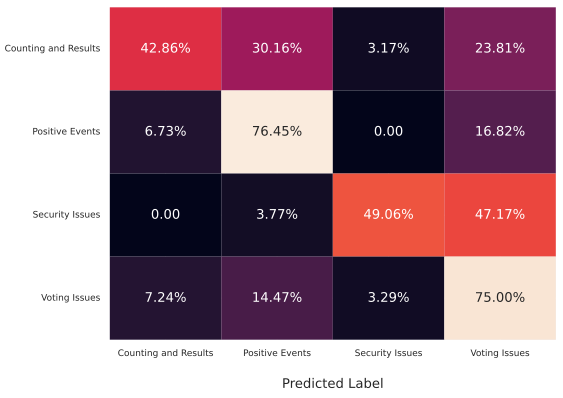

In [ ]:
flat_predictions = print_classification_report(predictions, true_labels, ng_mapping, name='xlmr-zeroshot.svg')

In [ ]:
# Clearly the model does not perform so well on zero shot setting?

In [ ]:
# Including some data in the training?

In [ ]:
train_data.shape

NameError: ignored

In [ ]:
# Including in the 100s and see how it performs?

In [ ]:
filtered_df.shape

(1051, 10)

In [ ]:
percentage_folds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8]
f1_scores = []

In [ ]:
# Train a separate model
ng_train_data, ng_test_data = train_test_split(filtered_df, train_size=0.8, stratify=filtered_df['informative_target'])
ng_train_embeddings = embedder.encode(ng_train_data.normalized_text.values)

In [ ]:
needed_data = train_data[train_data['merged_label'].isin(ng_mapping)]

In [ ]:
needed_data['merged_label'].unique()

array(['Positive Events', 'Security Issues', 'Counting and Results',
       'Voting Issues'], dtype=object)

In [ ]:
test_sample = needed_data.sample(700)

In [ ]:
test_sample_embeddings = embedder.encode(needed_data.normalized_text.values)

In [ ]:
test_sample_targets = needed_data.informative_target.values

In [ ]:
comb_train_embeddings = np.concatenate([ng_train_embeddings])
print(comb_train_embeddings.shape)
combined_train_targets = np.concatenate([ng_train_data.informative_target.values])

model_lr = LogisticRegression(max_iter=3000,class_weight='balanced')
model_lr.fit(comb_train_embeddings, combined_train_targets)

comb_test_embeddings = embedder.encode(ng_test_data.normalized_text.values)
pred = model_lr.predict(comb_test_embeddings)
print(classification_report(pred, ng_test_data.informative_target.values, target_names=ng_mapping))

(840, 768)
                      precision    recall  f1-score   support

Counting and Results       0.54      0.35      0.42        20
     Positive Events       0.73      0.73      0.73        66
     Security Issues       0.80      0.57      0.67        14
       Voting Issues       0.80      0.87      0.83       111

            accuracy                           0.76       211
           macro avg       0.72      0.63      0.66       211
        weighted avg       0.75      0.76      0.75       211



In [ ]:
import math

dataset_size = len(filtered_df)
increment_size = 20

# Calculate the total number of folds needed
num_folds = math.ceil(dataset_size / increment_size)

# Generate the list of fold sizes
fold_sizes = [min((i + 1) * increment_size, dataset_size) for i in range(num_folds)]

percentage_folds = [fold/dataset_size for fold in fold_sizes]

In [ ]:
percentage_folds

[0.019029495718363463,
 0.038058991436726926,
 0.05708848715509039,
 0.07611798287345385,
 0.09514747859181731,
 0.11417697431018078,
 0.13320647002854424,
 0.1522359657469077,
 0.17126546146527116,
 0.19029495718363462,
 0.2093244529019981,
 0.22835394862036157,
 0.24738344433872503,
 0.2664129400570885,
 0.285442435775452,
 0.3044719314938154,
 0.3235014272121789,
 0.3425309229305423,
 0.3615604186489058,
 0.38058991436726924,
 0.39961941008563273,
 0.4186489058039962,
 0.43767840152235965,
 0.45670789724072314,
 0.47573739295908657,
 0.49476688867745006,
 0.5137963843958135,
 0.532825880114177,
 0.5518553758325404,
 0.570884871550904,
 0.5899143672692674,
 0.6089438629876308,
 0.6279733587059942,
 0.6470028544243578,
 0.6660323501427212,
 0.6850618458610847,
 0.7040913415794482,
 0.7231208372978116,
 0.7421503330161751,
 0.7611798287345385,
 0.780209324452902,
 0.7992388201712655,
 0.8182683158896289,
 0.8372978116079924,
 0.8563273073263559,
 0.8753568030447193,
 0.8943862987630827

In [ ]:
for fold_size in percentage_folds:
  ng_train_data, ng_test_data = train_test_split(filtered_df, train_size=fold_size, stratify=filtered_df['informative_target'])
  ng_train_embeddings = embedder.encode(ng_train_data.normalized_text.values)

  comb_train_embeddings = np.concatenate([train_embeddings, ng_train_embeddings])
  combined_train_targets = np.concatenate([train_targets, ng_train_data.informative_target.values])

  model_lr = LogisticRegression(max_iter=3000,class_weight='balanced')
  model_lr.fit(comb_train_embeddings, combined_train_targets)

  comb_test_embeddings = embedder.encode(ng_test_data.normalized_text.values)
  pred = model_lr.predict(comb_test_embeddings)
  f1_scores.append(f1_score(pred, ng_test_data.informative_target.values, average='micro'))

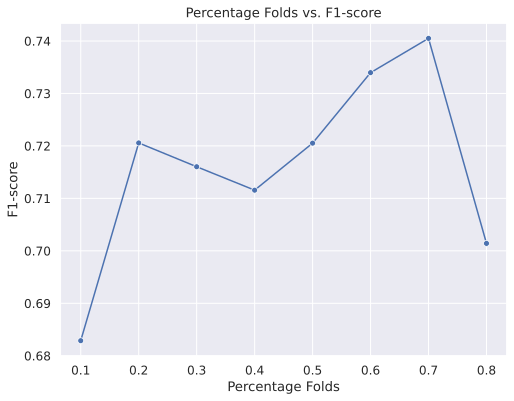

In [ ]:
# Using seaborn to create the line plot
plt.figure(figsize=(8, 6))
sns.lineplot(x=percentage_folds, y=f1_scores, marker='o', color='b')
plt.xlabel('Percentage Folds')
plt.ylabel('F1-score')
plt.title('Percentage Folds vs. F1-score')
plt.grid(True)
plt.show()

In [ ]:
print(classification_report(pred, ng_test_data.informative_target.values))

              precision    recall  f1-score   support

           0       0.43      0.32      0.37        66
           1       0.00      0.00      0.00         7
           2       0.65      0.74      0.69       227
           3       0.46      0.50      0.48        38
           4       0.80      0.78      0.79       482

    accuracy                           0.71       820
   macro avg       0.47      0.47      0.47       820
weighted avg       0.71      0.71      0.71       820



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
percentage_folds

[0.11904761904761904,
 0.23809523809523808,
 0.35714285714285715,
 0.47619047619047616,
 0.5952380952380952,
 0.7142857142857143,
 0.8333333333333334,
 0.9523809523809523,
 1.0]

In [ ]:
X_train = ng_train_data.normalized_text.values
y_train = ng_train_data.informative_target.values

In [ ]:
# Train a new XLM-R model from scratch

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

In [ ]:
def train_model(model, train_dataloader, val_dataloader, epochs, class_weights, optimizer, scheduler):
  training_stats = []
  total_t0 = time.time()
  for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()
    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader),
                num_desired_updates = 10
            )
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update.
        if (step % update_interval) == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       return_dict=True)

        logits = result.logits
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = criterion(logits, b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # print("")
    # print("Running Validation...")

    # t0 = time.time()

    # # Put the model in evaluation mode--the dropout layers behave differently
    # # during evaluation.
    # model.eval()

    # # Tracking variables
    # total_eval_loss = 0


    # predictions, true_labels = [], []

    # # Evaluate data for one epoch
    # for batch in val_dataloader:

    #     # Unpack this training batch from our dataloader.
    #     #
    #     # As we unpack the batch, we'll also copy each tensor to the GPU using
    #     # the `to` method.
    #     #
    #     # `batch` contains three pytorch tensors:
    #     #   [0]: input ids
    #     #   [1]: attention masks
    #     #   [2]: labels
    #     b_input_ids = batch[0].to(device)
    #     b_input_mask = batch[1].to(device)
    #     b_labels = batch[2].to(device)


    #     # Tell pytorch not to bother with constructing the compute graph during
    #     # the forward pass, since this is only needed for backprop (training).
    #     with torch.no_grad():

    #         # Forward pass, calculate logit predictions.
    #         # token_type_ids is the same as the "segment ids", which
    #         # differentiates sentence 1 and 2 in 2-sentence tasks.
    #         result = model(b_input_ids,
    #                        token_type_ids=None,
    #                        attention_mask=b_input_mask,
    #                        labels=b_labels,
    #                        return_dict=True)

    #     # Get the loss and "logits" output by the model. The "logits" are the
    #     # output values prior to applying an activation function like the
    #     # softmax.
    #     logits = result.logits

    #     # Calculate the loss without applying class weights
    #     criterion = torch.nn.CrossEntropyLoss(reduction='mean')
    #     loss = criterion(logits, b_labels)

    #     # Accumulate the validation loss.
    #     total_eval_loss += loss.item()

    #     # Calculate the accuracy for this batch of test sentences.

    #     # Move logits and labels to CPU
    #     logits = logits.detach().cpu().numpy()
    #     label_ids = b_labels.to('cpu').numpy()

    #     # Store predictions and true labels
    #     predictions.append(logits)
    #     true_labels.append(label_ids)

    # # Measure validation accuracy...

    # # Combine the results across all batches.
    # flat_predictions = np.concatenate(predictions, axis=0)
    # flat_true_labels = np.concatenate(true_labels, axis=0)

    # # For each sample, pick the label (0, 1, or 2) with the highest score.
    # predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

    # # Calculate the validation accuracy.
    # val_accuracy = (predicted_labels == flat_true_labels).mean()

    # # Report the final accuracy for this validation run.
    # print("  Accuracy: {0:.2f}".format(val_accuracy))

    # # Calculate the average loss over all of the batches.
    # avg_val_loss = total_eval_loss / len(val_dataloader)

    # # Measure how long the validation run took.
    # validation_time = format_time(time.time() - t0)

    # print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    # print("  Validation took: {:}".format(validation_time))

    # # Record all statistics from this epoch.
    # training_stats.append(
    #     {
    #         'epoch': epoch_i + 1,
    #         'Training Loss': avg_train_loss,
    #         'Valid. Loss': avg_val_loss,
    #         'Valid. Accur.': val_accuracy,
    #         'Training Time': training_time,
    #         'Validation Time': validation_time
    #     }
    # )

  return training_stats

In [ ]:
# Assuming you have your data and target labels in 'filtered_df'
train_data, test_data = train_test_split(filtered_df, train_size=0.10, random_state=42, stratify=filtered_df['label'])

# # Step 1: Split the 'train_data' into training and validation data
# train_data, val_data = train_test_split(train_data, train_size=0.875, random_state=42)

# Now, the 'train_data' contains 70% of the total data for training
# The 'val_data' contains 10% of the total data for validation
# The 'test_data' contains 20% of the total data for testing

# Print the sizes of each set
print("Train data size:", len(train_data))
# print("Validation data size:", len(val_data))
print("Test data size:", len(test_data))
print("Total Dataset:", len(filtered_df))

Train data size: 105
Test data size: 946
Total Dataset: 1051


In [ ]:
labeller = LabelEncoder()
labeller.fit(train_data["label"])
train_data["informative_target"] = labeller.transform(train_data["label"])
test_data["informative_target"] = labeller.transform(test_data["label"])
val_data["informative_target"] = labeller.transform(val_data["label"])

In [ ]:
mapping = dict(zip(labeller.classes_, range(len(labeller.classes_))))
print(mapping)

{'Counting and Results': 0, 'Positive Events': 1, 'Security Issues': 2, 'Voting Issues': 3}


In [ ]:
# Get train sentences and targets
train_sentences, train_targets = train_data.normalized_text.values, train_data.informative_target.values
# val_sentences, val_targets = val_data.normalized_text.values, val_data.informative_target.values
test_sentences, test_targets = test_data.normalized_text.values, test_data.informative_target.values

# Get class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_targets), y=train_targets)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

# Tokenize sentences
tokenizer = init_tokenizer()
train_input_ids, train_attention_masks, train_labels = tokenize_sent(tokenizer, 128, train_sentences, train_targets)
# val_input_ids, val_attention_masks, val_labels = tokenize_sent(tokenizer, 128, val_sentences, val_targets)
test_input_ids, test_attention_masks, test_labels = tokenize_sent(tokenizer, 128, test_sentences, test_targets)

# Create datasets
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
# val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Create dataloaders
train_dataloader = DataLoader(
      train_dataset,  # The training samples.
      sampler = RandomSampler(train_dataset), # Select batches randomly
      batch_size = 32 # Trains with this batch size.
  )

# # For validation the order doesn't matter, so we'll just read them sequentially.
# val_dataloader = DataLoader(
#             val_dataset, # The validation samples.
#             sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
#             batch_size = 32 # Evaluate with this batch size.
#         )

# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
          test_dataset, # The validation samples.
          sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
          batch_size = 32 # Evaluate with this batch size.
    )

In [ ]:
old_model = XLMRobertaForSequenceClassification.from_pretrained(f'/content/drive/My Drive/thesis/models/Multi-Class/Run2')

In [ ]:
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=4)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.roberta = old_model.roberta

In [ ]:
model.num_labels

4

In [ ]:
desc = model.to(device)

In [ ]:
len(train_data)

105

In [ ]:
epochs = 10
optimizer = torch.optim.AdamW(model.parameters(),
            lr = 2e-5, # args.learning_rate
            eps = 1e-6 # args.adam_epsilon  - default is 1e-8.
          )

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                          num_warmup_steps = 0,
                                          num_training_steps = total_steps)
train_stats = train_model(model, train_dataloader, None, epochs, class_weights, optimizer, scheduler)


======== Epoch 1 / 10 ========
Training...
  Batch     1  of      4.    Elapsed: 0:00:00.
  Batch     2  of      4.    Elapsed: 0:00:00.
  Batch     3  of      4.    Elapsed: 0:00:01.

  Average training loss: 0.36
  Training epoch took: 0:00:01

======== Epoch 2 / 10 ========
Training...
  Batch     1  of      4.    Elapsed: 0:00:00.
  Batch     2  of      4.    Elapsed: 0:00:00.
  Batch     3  of      4.    Elapsed: 0:00:01.

  Average training loss: 0.35
  Training epoch took: 0:00:01

======== Epoch 3 / 10 ========
Training...
  Batch     1  of      4.    Elapsed: 0:00:00.
  Batch     2  of      4.    Elapsed: 0:00:00.
  Batch     3  of      4.    Elapsed: 0:00:01.

  Average training loss: 0.23
  Training epoch took: 0:00:01

======== Epoch 4 / 10 ========
Training...
  Batch     1  of      4.    Elapsed: 0:00:00.
  Batch     2  of      4.    Elapsed: 0:00:00.
  Batch     3  of      4.    Elapsed: 0:00:01.

  Average training loss: 0.25
  Training epoch took: 0:00:01

======== Ep

In [ ]:
# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=train_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

KeyError: ignored

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i + 1 for i in range(0, epochs)])

plt.show()

KeyError: ignored

In [ ]:
predictions, true_labels = test_model(model, test_dataloader)

0.5728033817002722
                      precision    recall  f1-score   support

Counting and Results       0.31      0.14      0.19        57
     Positive Events       0.68      0.73      0.70       294
     Security Issues       0.55      0.62      0.58        48
       Voting Issues       0.81      0.82      0.81       547

            accuracy                           0.74       946
           macro avg       0.59      0.58      0.57       946
        weighted avg       0.73      0.74      0.73       946



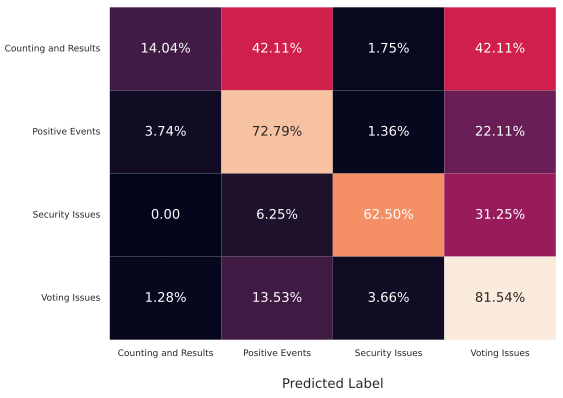

In [ ]:
flat_predictions = print_classification_report(predictions, true_labels, mapping.keys(), name='keenyan-xlmr-10.svg')

In [ ]:
# Experiment with Logistic Regression + SBERT

In [ ]:
print(train_data.shape, test_data.shape)

(105, 10) (946, 10)


In [ ]:
train_sentences, train_targets = train_data.normalized_text.values, train_data.informative_target.values

In [ ]:
test_sentences, test_targets = test_data.normalized_text.values, test_data.informative_target.values

In [ ]:
train_embeddings = embedder.encode(train_sentences, device=device)
model_lr = LogisticRegression(max_iter=3000, class_weight='balanced') # Set the max_iter to 1000 to fix convergence warning issue
model_lr.fit(train_embeddings, train_targets)
test_embeddings = embedder.encode(test_sentences, device=device)

In [ ]:
pred = model_lr.predict(test_embeddings)
print(f1_score(test_targets, pred, average='micro'))

0.7103594080338268


In [ ]:
print(classification_report(test_targets, pred,target_names=mapping.keys()))

                      precision    recall  f1-score   support

Counting and Results       0.26      0.35      0.30        57
     Positive Events       0.66      0.73      0.69       294
     Security Issues       0.56      0.56      0.56        48
       Voting Issues       0.83      0.75      0.79       547

            accuracy                           0.71       946
           macro avg       0.58      0.60      0.59       946
        weighted avg       0.73      0.71      0.72       946



In [ ]:
filtered_df[filtered_df['label'] == 'Voting Issues'][['Description', 'Survey']].sample(5)

,Description,Survey
142,No activities going on yet in this polling unit as there is no presence of INCE officials,Polling Station Issues
533,Counting of Votes Concluded and the Results are being Compiled,Polling Station Issues
314,It is exactly 11:06am the place is crowded and unorganized with many party agents and insufficient security personnel,Polling Station Issues
285,inec official just arrived.. voting is about to start,Polling Station Issues
1691,Incomplete ballot papers.,Ballot Issues
